In [285]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
import time
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/pdixit/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [286]:
device='cpu'

In [287]:
with open(f"Book1.txt", encoding="utf8") as f:
    book = f.read()
    book_pages = re.sub("Page.*?Rowling", "", book, flags=re.DOTALL)
    book_chapters = re.sub("(?:\\n){5,}[A-Z- \\n]+ (?:\\n){2,}", "", book_pages)
    book_line_breaks = re.sub("\\n", "", book_chapters)
    sentence_split = sent_tokenize(book_chapters)
    

In [288]:
processed_sentences = [sentence.lower() for sentence in sentence_split]

processed_sentences = [sent.lower() for sent in sentence_split if len(sent.strip()) > 0]


In [289]:
import string
vocab = string.ascii_lowercase + string.digits + string.punctuation + '“' + '”' + '’' + '—' + '‘' + " " + '•' 
stoi = {char: idx for idx, char in enumerate(vocab)}
itos = {idx: char for idx, char in enumerate(vocab)}
stoi['<S>'] = len(stoi)
itos[len(itos)] = '<S>'
vocab_size = len(stoi)


In [290]:
# Shuffle sentences
import random
random.seed(42)
random.shuffle(processed_sentences)

In [291]:
block_size = 100  # context length: how many characters do we take to predict the next one?

def build_dataset(sentences):  
    X, Y = [], []
    for sentence in sentences:
        context = [stoi['<S>']] * block_size  # Start with <S> token
        for ch in sentence + ' ':
            if ch not in stoi:  # Check if the character is in the vocabulary
                continue
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            
            # Slide the window: crop context to the last `block_size` characters and append the current character
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(f"X shape: {X.shape}, Y shape: {Y.shape}")
    return X, Y

# Split the data into train, dev, and test sets
n1 = int(0.8 * len(processed_sentences))  # 80% for training
n2 = int(0.9 * len(processed_sentences))  # 10% for dev
Xtr, Ytr = build_dataset(processed_sentences[:n1])  # Training data
Xdev, Ydev = build_dataset(processed_sentences[n1:n2])  # Validation data
Xte, Yte = build_dataset(processed_sentences[n2:])  # Test data

X shape: torch.Size([350021, 100]), Y shape: torch.Size([350021])
X shape: torch.Size([43670, 100]), Y shape: torch.Size([43670])
X shape: torch.Size([42532, 100]), Y shape: torch.Size([42532])


In [314]:
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), device=device) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out, device=device) if bias else None
  
  def __call__(self, x):
    
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # Parameters (trainable via backprop)
    self.gamma = torch.ones(dim, device=device).view(1, -1, 1)  # Shape [1, C, 1]
    self.beta = torch.zeros(dim, device=device).view(1, -1, 1)  # Shape [1, C, 1]
    # Buffers (updated via momentum)
    self.running_mean = torch.zeros(dim, device=device)  # Shape [C]
    self.running_var = torch.ones(dim, device=device)    # Shape [C]
  
  def __call__(self, x):
    if self.training:
      # Compute mean and variance across batch and sequence length (dim=(0,2))
      xmean = x.mean(dim=(0, 2), keepdim=True)  # Shape [1, C, 1]
      xvar = x.var(dim=(0, 2), keepdim=True)    # Shape [1, C, 1]
    else:
      # Use running statistics for inference
      xmean = self.running_mean.view(1, -1, 1)  # Shape [1, C, 1]
      xvar = self.running_var.view(1, -1, 1)    # Shape [1, C, 1]
    
    # Normalize input
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # Normalize to unit variance
    self.out = self.gamma * xhat + self.beta         # Scale and shift

    # Update running statistics during training
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean.squeeze()
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar.squeeze()
    
    return self.out
  
  def parameters(self):
    # Return trainable parameters
    return [self.gamma, self.beta]


# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim), device=device)
    
  def __call__(self, IX):
    self.out = self.weight[IX].transpose(1, 2)
    
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    def parameters(self):
        return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

# --------------------------------------------
class Conv1d:
    def __init__(self, sequence_length, in_channels, out_channels, kernel=2, stride=1, dilation=1):
        self. sequence_length = sequence_length
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel = kernel
        self.stride = stride
        self.dilation = dilation
        self.filters = torch.randn((out_channels, in_channels, kernel), device=device) * ((2 / (in_channels * kernel)) ** 0.5)
        self.bias = torch.randn(out_channels, device=device) * 0
        self.effective_kernel = ((self.kernel - 1) * self.dilation) + 1
        self.Lout = ((self.sequence_length - self.effective_kernel) // self.stride) + 1
    def __call__(self, x):
        # Compute effective kernel size based on dilation 
        # effective_kernel = ((self.kernel - 1) * self.dilation) + 1
        
        N, C, L = x.shape
        assert self.effective_kernel <= L
            
        # create the sliding windows of the input 
        x_unfolded = x.unfold(2, self.effective_kernel, self.stride)

        # Extract dilated inputs from x_unfolded which used effective_kernel. The shape of the unfolded vector is [N, C, L, effective_k] 
        # where L is the length of the sequence depending on the effective kernel. From the dimension of effective_kernel, we clip every 'dilated' index
        # If effective_kernel is 3 and dilation is 2, [1, 2, 3] will result in [1, 3]. [1,3] has length of 2, which is equal to actual kernel value
        x_unfolded = x_unfolded[:, :, :, ::self.dilation]

        # The dilation also changes the sequence length, since effective kernel value changes with dilation > 1. 
        # Compute Lout based on effective_kernel
        
        # Lout = ((self.sequence_length - self.effective_kernel) // self.stride) + 1
        
        # Before cross correlation, we need to broadcast the filters and the input correctly
        x_unfolded = x_unfolded.view(N, 1, C, self.Lout, self.kernel)
        filters = self.filters.view(1, self.out_channels, self.in_channels, 1, self.kernel)

        # Perform element wise multiplication
        self.out = torch.mul(x_unfolded, filters).sum((2, 4)) + self.bias.view(1, self.out_channels, 1)
        return self.out        
    
    def parameters(self): 
        return [self.filters] + [self.bias]

class ReLu: 
    def __call__(self, x):
        self.out = torch.relu(x)
        return self.out

    def parameters(self):
        return []
        
class Transpose:
    def __call__(self, x):
        self.out = x.transpose(1, 2)
        return self.out
    
    def parameters(self):
        return []

class Residual: 
    def __init__(self, layers):
        self.projection_needed = False
        self.layers = layers
        
        
        # Input of the in layer config
        in_layer = layers[0]
        out_layer = layers[-1]

        self.in_channels = in_layer.in_channels
        self.in_sequence_length = in_layer.sequence_length

        self.out_channels = out_layer.out_channels
        self.out_sequence_length = out_layer.Lout

        if self.in_channels != self.out_channels: # Assuming for now, this will always be the case
            self.projection_needed = True
            self.linear_projection_conv = Conv1d(sequence_length=self.in_sequence_length, out_channels=self.out_channels, in_channels=self.in_channels, kernel=1)
            
    def __call__(self, x):
        self.input = x
        for layer in self.layers: 
            x = layer(x)
        # Perform residual operation
        if self.projection_needed:
            linear_projection = self.linear_projection_conv(self.input)
            
        # Pad the output since the Lout != Lin
        sequence_length_diff = self.in_sequence_length - self.out_sequence_length
        x = F.pad(x, (sequence_length_diff // 2, sequence_length_diff - sequence_length_diff // 2))
        
        self.out = x + linear_projection if self.projection_needed else x + self.input
        
        return self.out
        
    def parameters(self):
        # Collect parameters from all layers and the projection (if used)
        params = [p for layer in self.layers for p in layer.parameters()]
        if self.projection_needed:
            params += self.linear_projection_conv.parameters()
        return params

class ElmanRNN:
    def __init__(self, input_channels, hidden_channels): # Bias would be present. Tanh non linearity will be applied. 
        self.wxh = torch.randn((input_channels, hidden_channels), device=device) * (5/3 / (input_channels) ** 0.5)
        self.bxh = torch.randn((1, hidden_channels), device=device) * 0.001
        
        self.whh = torch.randn((hidden_channels, hidden_channels), device=device) * (5/3 / (hidden_channels) ** 0.5)
        self.bhh = torch.randn((1, hidden_channels), device=device) * 0.001
        
        self.hidden_channels = hidden_channels
        self.input_channels = input_channels

    def __call__(self, x):
        N, C, L = x.shape

        # Iterate over the entire sequence length and generate logits. The shape of the output logits will be [N, Hout, L]
        logits = torch.zeros((N, self.hidden_channels, L), device=device)
        H = torch.zeros((N, self.hidden_channels), device=device)
        for i in range(L):
            xi = x[:, :, i]
            xih = (xi @ self.wxh) + self.bxh
            hh = (H @ self.whh) + self.bhh
            ht = torch.tanh(xih + hh)
            
            H = ht 
            logits[:, :, i] = ht
            self.out = logits
            
        return self.out

    def parameters(self):
        return [self.wxh] + [self.whh] + [self.bxh] + [self.bhh]

class LSTM:
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Define gate weights 
        # Input Gate weights
        self. wii = torch.randn((input_size, hidden_size))
        self.whi = torch.randn((hidden_size, hidden_size))
        self.bii = torch.randn(hidden_size)
        
        # Forget Gate weights 
        self.wif = torch.randn((input_size, hidden_size))
        self.whf = torch.randn((hidden_size, hidden_size))
        self.bif = torch.randn(hidden_size)

        # Cell candidiate weights 
        self.wig = torch.randn((input_size, hidden_size))
        self.whg = torch.randn((hidden_size, hidden_size))
        self.big = torch.randn(hidden_size)
        # Output gate weights 
        self.wio = torch.randn((input_size, hidden_size))
        self.who = torch.randn((hidden_size, hidden_size))
        self.bio = torch.randn(hidden_size)

    def __call__(self, x, H=None, C=None):
        # Shape of x will be [N, C, L]. N = batch size, C = input channel size, L = input sequence length 
        N, I, L = x.shape 
        if H == None:
            H = torch.zeros((N, self.hidden_size))
        if C == None: 
            C = torch.zeros((N, self.hidden_size))
        logits = torch.zeros((N, self.hidden_size, L))
        for i in range(x.shape[2]):
            xi = x[:, :, i]
            # Compute gate vectors 
            it = torch.sigmoid((xi @ self.wii) + (H @ self.whi) + self.bii)
            ft = torch.sigmoid((xi @ self.wif) + (H @ self.whf) + self.bif)
            gt = torch.tanh((xi @ self.wig) + (H @ self.whg) + self.big)
            ot = torch.sigmoid((xi @ self.wio) + (H @ self.who) + self.bio)
            ct = (ft * C) + (it * gt)
            C = ct
            ht = ot * torch.tanh(ct)
            H = ht
            logits[:, :, i] = ht
        self.out = logits
        self.C = C
        return self.out, self.C
    def parameters(self):
        return [self.wii, self.whi, self.bii] + [self.wif, self.whf, self.bif] + [self.wig, self.whg, self.big] + [self.wio, self.who, self.bio]

class LayeredLSTM:
    def __init__(self, layers):
        self.layers = layers


    def __call__(self, x, h=None, c=None):
        N, I, L = x.shape  # N=batch size, I=input channels, L=sequence length

        if h is None:
            h = [torch.zeros((N, layer.hidden_size)) for layer in self.layers]
        if c is None:
            c = [torch.zeros((N, layer.hidden_size)) for layer in self.layers]

        for i, layer in enumerate(self.layers):
            x, cell_state = layer(x, h[i], c[i])
            h[i] = x[:, :, -1]
            c[i] = cell_state
        
        return x
    def parameters(self): 
        return [p for layer in self.layers for p in layer.parameters()]

        

In [322]:
n_embeddings = 24
h_channels = 100
h2_channels = 100
# h3_channels = 500
# h4_channels = 100
# h4_channels = 100

model = Sequential([
    Embedding(vocab_size, n_embeddings),
    LayeredLSTM([
        LSTM(n_embeddings, h_channels),
        LSTM(h_channels, h2_channels),
    ]),
    
    Flatten(), Linear(h2_channels * block_size, vocab_size)
])
# parameters = [p for layer in layers for p in layer.parameters()]
print(f"parameters: {sum(p.nelement() for p in model.parameters())}")

for p in model.parameters():
        p.requires_grad = True

parameters: 892300


In [323]:
lossi = []

In [324]:
batch_size = 32
start_time = time.time_ns()
max_steps = 100000
for i in range(max_steps): 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] 
    
    # Forward pass 
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    
    # backward 
    for p in model.parameters():
        p.grad = None
    loss.backward() 
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
    
    # Update the parameters 
    e = 0.01  if i < 20_000 else 0.005
    for p in model.parameters():
        p.data += -e * p.grad
    
    if i % 1000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
end_time = time.time_ns() 
print(f"Total time: {(end_time - start_time) / 1_000_000_000}")

      0/ 100000: 4.3848
   1000/ 100000: 4.3948
   2000/ 100000: 4.4629
   3000/ 100000: 4.4761
   4000/ 100000: 4.4475
   5000/ 100000: 4.4450
   6000/ 100000: 4.3374
   7000/ 100000: 4.2687
   8000/ 100000: 4.2818
   9000/ 100000: 4.3929
  10000/ 100000: 4.3480
  11000/ 100000: 4.4516


KeyboardInterrupt: 

In [296]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

In [ ]:
for layer in model.layers:
    layer.training = False
    
# split_loss('train')
split_loss('val')

In [298]:
def sample_from_model(num_samples=2, max_length=100, temperature=1.0):
    """
    Samples sentences from the model.
    
    Parameters:
    - num_samples: Number of sentences to generate.
    - max_length: Maximum length of each generated sentence.
    - temperature: Sampling temperature to control randomness.
    
    Returns:
    - res: List of generated sentences.
    """
    res = []
    for _ in range(num_samples):
        out = []
        context = [stoi['<S>']] * block_size  # Initialize with all `<S>` tokens
        for _ in range(max_length):
            # Forward pass through the neural network
            logits = model(torch.tensor([context], dtype=torch.long))  # Shape: (1, block_size)
            
            # If Flatten is used, logits will be (1 * block_size, vocab_size), so adjust:
            logits = logits[-1, :]  # Take the logits for the last character
            
            # Apply temperature scaling
            logits = logits / temperature
            probs = F.softmax(logits, dim=0)
            
            # Sample from the probability distribution
            ix = torch.multinomial(probs, num_samples=1).item()
            
            # Shift the context window and track the samples
            context = context[1:] + [ix]
            out.append(ix)
            
            # If the end token `<E>` or `.` is sampled, stop generation
            if ix == stoi.get('.'):
                break
        
        # Decode and append the generated sentence
        res.append(''.join(itos[i] for i in out))
    return res


In [299]:
sample_from_model()

['marrys ane a aace said sy uta bedd leser acringitt as hoic o wpy ofwitar satred frip, ald sssape” do',
 '““r thee’sy cous aid seder, sued dranpenazbscaryybatn ae clute t oguta toen .']

In [300]:
lossi = torch.tensor(lossi)


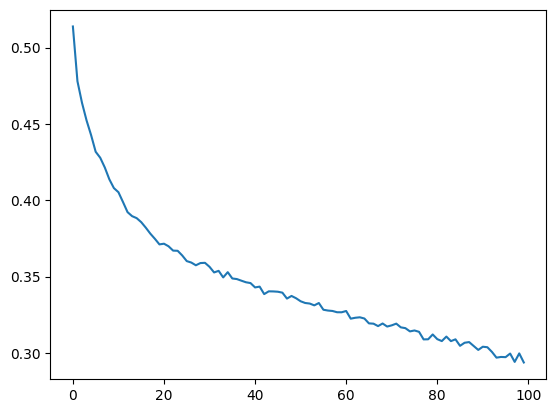

In [301]:
plt.plot(lossi.view(-1, 1000).mean(1))

In [307]:
''.join([itos[c] for c in Xdev[96].tolist()])


'<S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S>his stomach twisted as he imagi'

In [308]:
context = [stoi['<S>']] * block_size
context = torch.tensor(context).view(1, -1)
probs = F.softmax(model(torch.tensor(context)), dim=1)


/var/folders/84/r3s7dwr93cs3k0kzl447b_8c0000gp/T/ipykernel_82803/1197392954.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  probs = F.softmax(model(torch.tensor(context)), dim=1)


In [309]:
ix = torch.multinomial(probs, num_samples=1).item()

In [310]:
itos[ix]

'w'

In [311]:
def sample_from_model(model, stoi, itos, block_size, max_length=200, temperature=1.0, seed="<S>"):
    """
    Generates a sequence of characters from the trained model.
    
    Parameters:
    - model: Trained PyTorch model
    - stoi: Dictionary mapping characters to indices
    - itos: Dictionary mapping indices to characters
    - block_size: Context size (length of input sequence to model)
    - max_length: Maximum length of the generated sequence
    - temperature: Softmax temperature for controlling randomness in sampling
    - seed: Initial context to start generation
    
    Returns:
    - generated_text: The generated sequence as a string
    """
    # Start with the seed sequence
    # context = [stoi[ch] for ch in seed if ch in stoi]  # Convert seed to indices
    context = [stoi['<S>']] * (block_size)
    print(context)
    generated_indices = []
    
    for _ in range(max_length):
        # Prepare input tensor
        x = torch.tensor([context], dtype=torch.long)  # Shape: (1, block_size)
        
        # Forward pass through the model
        logits = model(x)  # Shape: (1 * block_size, vocab_size)
        logits = logits[-1, :]  # Take the logits for the last character in the sequence
        
        # Adjust for temperature
        logits = logits / temperature
        probs = F.softmax(logits, dim=-1)
        
        # Sample from the probability distribution
        idx = torch.multinomial(probs, num_samples=1).item()
        
        # Add the predicted character to the generated output
        generated_indices.append(idx)
        context = context[1:] + [idx]  # Slide the context window
        
        # Stop if the end token `<E>` is generated
        if itos[idx] == ".":
            break
    
    # Convert indices back to characters
    generated_text = ''.join([itos[idx] for idx in generated_indices if itos[idx] not in {"<S>", "<E>"}])
    return generated_text


In [312]:
seed_text = "<S>"  # Start token for generation
generated_text = sample_from_model(model, stoi, itos, block_size=100, max_length=200, temperature=0.8, seed=seed_text)
print("Generated text:", generated_text)

[75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75]
Generated text: the carling iand s” ped testhey.


In [208]:
context = [stoi['<S>']] * block_size
s = 'a centaur was standing over him, not ronan or bane; '

l = len(s)
for i, c in enumerate(s):
    context[block_size - l + i] = stoi[c]


In [210]:
''.join([itos[c] for c in context])

'<S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S><S>a centaur was standing over him, not ronan or bane; '